In [21]:
# ======================================
# 📦 1. Setup & Imports
# ======================================
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from datasets import load_dataset, concatenate_datasets, DatasetDict
from transformers import GPT2TokenizerFast, GPT2ForSequenceClassification, set_seed

In [22]:
# ======================================
# ⚙️ 2. Configuration
# ======================================
SEED = 42
set_seed(SEED)

PROJECT_DIR = "/content/drive/MyDrive/gpt2_agnews_project"
MODEL_DIR = os.path.join(PROJECT_DIR, "model_output", "checkpoint-12760")
QUANT_MAP_PATH = os.path.join(PROJECT_DIR, "gpt2_int8_quant_map.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cuda


In [24]:
# ======================================
# ⚙️ 2. Configuration
# ======================================
SEED = 42
set_seed(SEED)

MODEL_DIR = os.path.join("checkpoint-12760")
QUANT_MAP_PATH = os.path.join("quant_scratch", "gpt2_int8_quant_map.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

✅ Using device: cuda


In [25]:
# ======================================
# 📂 3. Load Dataset
# ======================================
dataset = load_dataset("ag_news")
full_dataset = concatenate_datasets([dataset["train"], dataset["test"]]).shuffle(seed=SEED)

train_testvalid = full_dataset.train_test_split(test_size=0.2, seed=SEED)
valid_test = train_testvalid["test"].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    "train": train_testvalid["train"],
    "validation": valid_test["train"],
    "test": valid_test["test"]
})

texts = dataset["test"]["text"]
labels = np.array(dataset["test"]["label"])
print(f"✅ Dataset Loaded: Test Size = {len(dataset['test'])}")

✅ Dataset Loaded: Test Size = 12760


In [26]:
# # ======================================
# # 🤗 4. Load Fine-Tuned Model
# # ======================================
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_DIR)
# model_fp32 = GPT2ForSequenceClassification.from_pretrained(MODEL_DIR)
# model_fp32.eval()
# model_fp32.to(device)
# print("✅ Loaded fine-tuned GPT-2 model")

In [31]:
# ======================================
# 🧮 5. Symmetric INT8 Quantization Functions
# ======================================
def quantize_fp32_to_int8(tensor):
    """Symmetric per-tensor int8 quantization."""
    max_abs = tensor.abs().max()
    scale = (max_abs / 127.0).item() if max_abs != 0 else 1.0
    quantized_tensor = (tensor / scale).round().clamp(-127, 127).to(torch.int8)
    zero_point = 0.0
    return quantized_tensor, scale, zero_point

def dequantize_int8_to_fp32(quantized_tensor, scale, zero_point):
    return quantized_tensor.to(torch.float32) * scale + zero_point

def quantize_model_symmetric_int8_with_memory(model_dir, device):
    """
    Quantizes all weight tensors symmetrically to INT8 and computes memory footprint.
    Returns: (q_model, quant_map, mem_stats)
    """
    from transformers import GPT2ForSequenceClassification

    quant_map = {}
    q_model = GPT2ForSequenceClassification.from_pretrained(model_dir)
    q_model.eval()

    # Track memory
    total_fp32_params = 0
    total_fp32_bytes = 0
    total_int8_params = 0
    total_int8_bytes = 0

    for name, param in q_model.named_parameters():
        total_fp32_params += param.numel()
        total_fp32_bytes += param.numel() * param.element_size()  # FP32 size

        if name.endswith('weight') and param.data.dim() >= 2:
            # Quantize
            q_weight, scale, zp = quantize_fp32_to_int8(param.data.detach().cpu())
            quant_map[name] = (q_weight, scale, zp)

            # Track INT8 stats
            total_int8_params += q_weight.numel()
            total_int8_bytes += q_weight.numel() * q_weight.element_size()

            # Keep quantized-then-dequantized version for model inference
            param.data = dequantize_int8_to_fp32(q_weight, scale, zp).to(param.data.device)
        else:
            # Non-quantized parameters (bias, LN params)
            total_int8_params += param.numel()
            total_int8_bytes += param.numel() * param.element_size()  # still FP32

    q_model.to(device)

    mem_stats = {
        "FP32_params": total_fp32_params,
        "FP32_memory_MB": total_fp32_bytes / (1024**2),
        "INT8_params": total_int8_params,
        "INT8_equiv_memory_MB": total_int8_bytes / (1024**2),
        "Compression_Ratio": total_fp32_bytes / total_int8_bytes
    }

    return q_model, quant_map, mem_stats


In [29]:
# ======================================
# 💾 6. Model Parameter Memory Footprint
# ======================================
def get_model_param_memory(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    return total_params, total_bytes / (1024**2)  # MB

In [30]:
# ======================================
# ⚡ 7. Evaluation Function
# ======================================
def evaluate_model(model, texts, labels, batch_size=16):
    model.eval()
    preds, latencies = [], []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Evaluating INT8 Model"):
            batch_texts = texts[i:i+batch_size]
            encodings = tokenizer(
                batch_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=256
            ).to(device)

            start = time.time()
            outputs = model(**encodings)
            end = time.time()

            latencies.append((end - start) * 1000 / len(batch_texts))
            preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

    avg_latency = np.mean(latencies)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    cm = confusion_matrix(labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "latency_ms": avg_latency,
        "confusion_matrix": cm
    }

In [32]:
# ======================================
# 🧊 8. Quantize & Evaluate
# ======================================
print("\n⚙️ Applying symmetric INT8 quantization...")
quant_model, quant_map , mem_stats = quantize_model_symmetric_int8_with_memory(MODEL_DIR, device)
print("✅ Quantization complete. Evaluating quantized model...")

metrics = evaluate_model(quant_model, texts, labels)
params, mem = get_model_param_memory(quant_model)


⚙️ Applying symmetric INT8 quantization...


✅ Quantization complete. Evaluating quantized model...


Evaluating INT8 Model: 100%|██████████| 798/798 [00:31<00:00, 25.38it/s]


In [33]:
# ======================================
# 📈 9. Print Results
# ======================================
print("\n📊 INT8 Quantized Model Metrics:")
for k, v in metrics.items():
    if k != "confusion_matrix":
        print(f"{k:12}: {v:.4f}" if isinstance(v, float) else f"{k:12}: {v}")
print(f"💾 Parameter Memory: {mem:.2f} MB ({params:,} parameters)")

print(mem_stats)


📊 INT8 Quantized Model Metrics:
accuracy    : 0.9447
precision   : 0.9446
recall      : 0.9447
f1          : 0.9446
latency_ms  : 1.0667
💾 Parameter Memory: 474.71 MB (124,442,880 parameters)
{'FP32_params': 124442880, 'FP32_memory_MB': 474.7119140625, 'INT8_params': 124442880, 'INT8_equiv_memory_MB': 119.025146484375, 'Compression_Ratio': 3.9883329538671703}


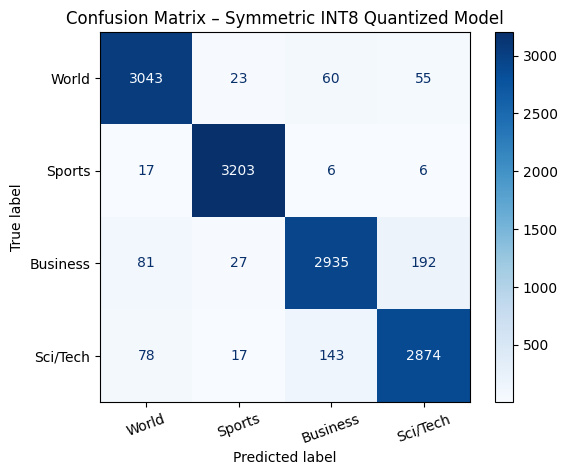

In [34]:
# ======================================
# 📉 10. Confusion Matrix
# ======================================
disp = ConfusionMatrixDisplay(
    confusion_matrix=metrics["confusion_matrix"],
    display_labels=["World", "Sports", "Business", "Sci/Tech"]  # keyword argument
)
disp.plot(cmap="Blues", xticks_rotation=20)
plt.title("Confusion Matrix – Symmetric INT8 Quantized Model")
plt.show()
